# Updated Baseline
The code and results below correspond to an upgraded baseline upon the Landslide4Sense dataset. The actual baseline suggested by the dataset was 56% in F1 and 76% in MLou. Here, I replicated the baseline and added my own touches to see how it affects our results.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install and configure
!pip install --quiet kaggle
from google.colab import files
files.upload()                         # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download tekbahadurkshetri/landslide4sense \
-p /content/landslide_data --unzip

Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other
 96% 2.75G/2.85G [00:05<00:00, 671MB/s]
100% 2.85G/2.85G [00:05<00:00, 517MB/s]


## Initial Setup and Tests
General focus here is to just get a feel of the data, its dimensions and how we can use for eventual training. Below are cells that:


*   Mount our drive (where the data is located) and initalizes paths.
*   pip install and import all required packages for our baseline.



In [4]:
BASE_PATH = "/content"
DATA_PATH = f"{BASE_PATH}/landslide_data"


In [5]:
!pip install pandas numpy torch torchvision torchaudio h5py -q
!pip install opencv-python matplotlib segmentation-models-pytorch albumentations tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


## Imports and Sanity checks

In [6]:
import torch
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import h5py
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Test Data and check type, verified it here.

sample_path = f"{DATA_PATH}/TrainData/img/image_1.h5"  # adjust this to match one of your file names

with h5py.File(sample_path, 'r') as f:
    print(list(f.keys()))  # shows all datasets inside the file
    data = f['img'][:]   # try reading the image data (dataset name might be different, we’ll check)
    print("Data shape:", data.shape)

mask_path = f"{DATA_PATH}/TrainData/mask/mask_1.h5"

with h5py.File(mask_path, 'r') as f:
    print(f.keys())  # find correct key
    mask = f['mask'][:]  # or whatever the key is
    print("Mask shape:", mask.shape)
    print("Unique values:", np.unique(mask))


['img']
Data shape: (128, 128, 14)
<KeysViewHDF5 ['mask']>
Mask shape: (128, 128)
Unique values: [0 1]


## Data Initialization & Feature Engineering
This Section focuses on initializing our .h5 image data. We also create new feature bands for our model in this section

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1) Band‑engineering function
def compute_26_bands(raw):
    """
    raw: np.ndarray of shape (14, H, W)
    returns: np.ndarray of shape (26, H, W)
    """
    B2, B3, B4 = raw[1], raw[2], raw[3]
    B8, B11, B12 = raw[7], raw[10], raw[11]

    # Normalize B2, B3, B4
    def norm(b): return (b - b.min())/(b.max() - b.min() + 1e-8)
    B2n, B3n, B4n = norm(B2), norm(B3), norm(B4)

    # Spectral indices
    ndvi = (B8 - B4) / (B8 + B4 + 1e-8)
    ndmi = (B8 - B11) / (B8 + B11 + 1e-8)
    nbr  = (B8 - B12) / (B8 + B12 + 1e-8)

    # Grayscale
    gray = (B2 + B3 + B4) / 3.0

    # Smoothing (odd kernels)
    gauss  = cv2.GaussianBlur(gray,  (11, 11), 0)
    median = cv2.medianBlur((gray*255).astype(np.uint8), 11) / 255.0

    # Gradients
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Edge map
    canny = cv2.Canny((gray*255).astype(np.uint8), 100, 200) / 255.0

    # Stack extras as (1, H, W)
    extras = [e[np.newaxis, ...] for e in [
        B2n, B3n, B4n,
        ndvi, ndmi, nbr,
        gray, gauss, median,
        gradx, grady, canny
    ]]

    return np.concatenate([raw] + extras, axis=0)


# 2) Dataset class
class LandSlideHSDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.transform  = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load raw 14-band image (H, W, 14)
        with h5py.File(self.img_paths[idx], 'r') as f:
            raw14 = f['img'][:]             # NumPy (H, W, 14)

        # Compute 26 bands
        raw14_chw = np.transpose(raw14, (2, 0, 1))  # (14, H, W)
        full26_chw = compute_26_bands(raw14_chw)[:23]    # (26, H, W)
        img = np.transpose(full26_chw, (1, 2, 0))   # (H, W, 26)

        # Load mask (H, W)
        with h5py.File(self.mask_paths[idx], 'r') as f:
            mask = f['mask'][:]                   # NumPy (H, W)

        # Apply Albumentations transforms
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        # img is now Tensor (C=26, H, W); mask is Tensor (H, W)
        img_tensor  = img.float()
        mask_tensor = mask.unsqueeze(0).float()     # add channel dim → (1, H, W)

        return img_tensor, mask_tensor


# 3) Define transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

# 4) Instantiate & test
DATA_PATH = f"{BASE_PATH}/landslide_data"
ds = LandSlideHSDataset(
    img_paths=[
        f"{DATA_PATH}/TrainData/img/image_1.h5",
        f"{DATA_PATH}/TrainData/img/image_2.h5",
    ],
    mask_paths=[
        f"{DATA_PATH}/TrainData/mask/mask_1.h5",
        f"{DATA_PATH}/TrainData/mask/mask_2.h5",
    ],
    transform=train_transform
)
print("Dataset length:", len(ds))
img_tensor, mask_tensor = ds[0]
print("Image tensor shape:", img_tensor.shape)  # expect (26, 128, 128)
print("Mask tensor shape: ", mask_tensor.shape) # expect (1, 128, 128)

Dataset length: 2
Image tensor shape: torch.Size([23, 256, 256])
Mask tensor shape:  torch.Size([1, 256, 256])


In [9]:
# Use Dataloaders and split the Training data into a 80/20 Split.

from torch.utils.data import WeightedRandomSampler

img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"

all_img_paths = sorted([
    os.path.join(img_dir,  fname)
    for fname in os.listdir(img_dir)
    if fname.endswith('.h5')
])

all_mask_paths = sorted([
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith('.h5')
])

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# This will shuffle and split in one go:
img_train, img_val, mask_train, mask_val = train_test_split(
    all_img_paths, all_mask_paths,
    test_size=0.2,      # 20% validation
    random_state=42     # fixed seed for reproducibility
)

# Assuming data_transform is defined in a previous cell
train_ds = LandSlideHSDataset(img_train, mask_train, transform=train_transform)
val_ds   = LandSlideHSDataset(img_val,   mask_val,   transform=val_transform)

sample_weights = []
for img_path, mask_path in zip(img_train, mask_train):
    # load mask quickly
    with h5py.File(mask_path, 'r') as f:
        mask = f['mask'][:]
    has_pos = mask.sum() > 0
    # give a weight of 1.0 to positive patches, 0.1 to negative ones
    sample_weights.append(1.0 if has_pos else 0.4)

# 2) Create a WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, sampler=sampler,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# Check lengths & shapes
print(len(train_loader), len(val_loader))
imgs, msks = next(iter(train_loader))
print(imgs.shape, msks.shape)

380 95
torch.Size([8, 23, 256, 256]) torch.Size([8, 1, 256, 256])


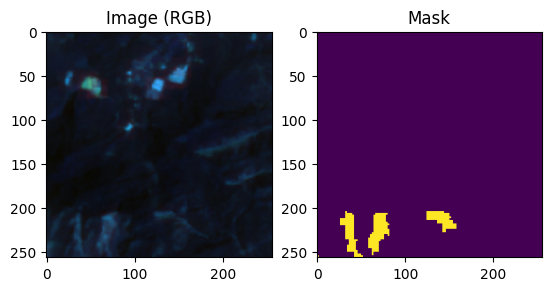

In [10]:
img, mask = ds[0]

# Normalize the image for display
img_display = img.permute(1,2,0)[:, :, :3].numpy()
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

plt.subplot(1,2,1)
plt.imshow(img_display)
plt.title("Image (RGB)")
plt.subplot(1,2,2)
plt.imshow(mask[0].numpy())
plt.title("Mask")
plt.show()

## Model Initialization

i initialize and set up the loss, network and optimizer here. This section is critical!

In [13]:
# ─── Cell: Model ▸ Device ▸ Quick-train Sanity Check ─────────────────────────────

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import h5py
import numpy as np


# Ensure 'device' is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_model(in_ch):
    """
    Build a segmentation model, its loss function, and optimizer.
    """
    # Model: U-Net with SegFormer-B0 backbone
    model = smp.FPN(
        encoder_name='efficientnet-b3',
        encoder_weights='advprop',
        in_channels=in_ch,
        classes=1,
        activation=None
    ).to(device)


    bce = nn.BCEWithLogitsLoss()


    # Loss components

    dice  = smp.losses.DiceLoss(mode='binary')
    focal = smp.losses.FocalLoss(mode='binary')
    jacc  = smp.losses.JaccardLoss(mode='binary')

    #coefficients for each loss
    a_bce   = 1.0
    a_focal = 0.5
    a_jacc = 0.5


    def loss_fn(logits, targets):
        probs = torch.sigmoid(logits)
        return a_bce * bce(logits, targets) + a_jacc * jacc(torch.sigmoid(logits), targets) + a_focal * focal(torch.sigmoid(logits), targets)


    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, loss_fn, optimizer

import torch, torch.nn as nn
from itertools import islice
from tqdm.auto import tqdm

# 1) DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n▶ Using device: {device}\n")

# 2) BUILD MODEL + LOSSES + OPTIMIZER
# (Make sure make_model takes in_ch as argument)
in_ch = 23   # ← or however many bands you have
model, loss_fn, optimizer = make_model(in_ch)
model.to(device)
print(model, "\n")    # simple summary

# 3) QUICK-TRAIN SANITY CHECK ON 1 BATCH
def small_loader(loader, max_batches=1):
    return islice(loader, max_batches)

# Run one batch through forward+backward to confirm everything wires up
batch = next(small_loader(train_loader, 1), None)
if batch is not None:
    imgs, masks = batch
    imgs, masks = imgs.to(device), masks.to(device)

    model.train()
    optimizer.zero_grad()
    logits = model(imgs)
    loss   = loss_fn(logits, masks)
    loss.backward()
    optimizer.step()

    print(f"✔ Sanity-check loss on 1 batch: {loss.item():.4f}\n")
else:
    print("⚠️  train_loader is empty—cannot run sanity check.\n")


▶ Using device: cuda



config.json:   0%|          | 0.00/94.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      23, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Ident

## Development Loop
a step i deemed exceptionally important. This is to basically check if the actual logic is working before committing resources and time to a full train. This only trains and maps 3 epochs.

In [14]:
# Evaluating and developing the training loop
from tqdm import tqdm
from time import sleep
from sklearn.metrics import f1_score
import numpy as np
import torch

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    batch_count  = 0

    loop = tqdm(loader, desc='Training', leave=False)
    for images, masks in loop:
        batch_count += 1

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg = running_loss / batch_count
        loop.set_postfix(train_loss=f"{avg:.4f}")

    return running_loss / batch_count


def validate_one_epoch(model, loader, device, loss_fn, threshold=0.5):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []

    loop = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            loss   = loss_fn(logits, masks)

            running_loss += loss.item()
            loop.set_postfix(val_loss=f"{running_loss/((loop.n+1)*images.size(0)):.4f}")

            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            preds = (probs > threshold).astype(int)
            y_true.append(masks.cpu().numpy().ravel().astype(int))
            y_pred.append(preds)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)

    return running_loss / len(loader.dataset), f1, precision, recall

    # Calculate F1 score
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return running_loss / batch_count, f1 # Return both loss and f1

## Actual Training Loop
This is the main training loop where the whole training takes place. 20 epochs trained and models are saved at checkpoints (in case of interruptions).
The code is designed to be fail-safe and tells us the results we need at the end of this execution.


▶ Using device: cuda

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      23, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          

Epoch01 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch01 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E01] tr_loss=0.6600  val_loss=0.6214  f1=0.6489  prec=0.6564  rec=0.6416  best_thresh=0.60  (94.2s)  ← best loss  ← best F1


Epoch02 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch02 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E02] tr_loss=0.6259  val_loss=0.6169  f1=0.5586  prec=0.8848  rec=0.4081  best_thresh=0.50  (103.3s)  ← best loss


Epoch03 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch03 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E03] tr_loss=0.6203  val_loss=0.6096  f1=0.6547  prec=0.8209  rec=0.5444  best_thresh=0.50  (104.3s)  ← best loss  ← best F1


Epoch04 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch04 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E04] tr_loss=0.6155  val_loss=0.6081  f1=0.6683  prec=0.8241  rec=0.5620  best_thresh=0.50  (133.7s)  ← best loss  ← best F1


Epoch05 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch05 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E05] tr_loss=0.6123  val_loss=0.6097  f1=0.7124  prec=0.7076  rec=0.7173  best_thresh=0.50  (94.1s)  ← best F1


Epoch06 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch06 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E06] tr_loss=0.6108  val_loss=0.6056  f1=0.7242  prec=0.7415  rec=0.7076  best_thresh=0.50  (105.6s)  ← best loss  ← best F1


Epoch07 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch07 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E07] tr_loss=0.6101  val_loss=0.6064  f1=0.7000  prec=0.8166  rec=0.6126  best_thresh=0.50  (96.6s)


Epoch08 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch08 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E08] tr_loss=0.6086  val_loss=0.6037  f1=0.7116  prec=0.8128  rec=0.6328  best_thresh=0.50  (110.4s)  ← best loss


Epoch09 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cbe9dda2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cbe9dda2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch09 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E09] tr_loss=0.6082  val_loss=0.6045  f1=0.6932  prec=0.8403  rec=0.5899  best_thresh=0.50  (164.6s)


Epoch10 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch10 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E10] tr_loss=0.6066  val_loss=0.6027  f1=0.7284  prec=0.8029  rec=0.6665  best_thresh=0.50  (104.5s)  ← best loss  ← best F1


Epoch11 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cbe9dda2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x79cbe9dda2a0>

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():
     self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): 
  ^ ^^ ^ ^ ^ ^ ^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ 
   File "/usr/lib/py

Epoch11 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E11] tr_loss=0.6064  val_loss=0.6026  f1=0.7371  prec=0.7794  rec=0.6993  best_thresh=0.50  (94.1s)  ← best loss  ← best F1


Epoch12 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch12 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E12] tr_loss=0.6050  val_loss=0.6030  f1=0.7249  prec=0.8074  rec=0.6576  best_thresh=0.50  (92.0s)


Epoch13 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch13 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E13] tr_loss=0.6037  val_loss=0.6024  f1=0.7409  prec=0.7691  rec=0.7148  best_thresh=0.50  (102.5s)  ← best loss  ← best F1


Epoch14 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cbe9dda2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: 
AssertionError: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x79cbe9dda2a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 160

Epoch14 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E14] tr_loss=0.6032  val_loss=0.6028  f1=0.7215  prec=0.8203  rec=0.6439  best_thresh=0.50  (153.4s)


Epoch15 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch15 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E15] tr_loss=0.6034  val_loss=0.6036  f1=0.7160  prec=0.8266  rec=0.6315  best_thresh=0.50  (103.5s)


Epoch16 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch16 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E16] tr_loss=0.6023  val_loss=0.6013  f1=0.7409  prec=0.7974  rec=0.6919  best_thresh=0.50  (102.9s)  ← best loss


Epoch17 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch17 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E17] tr_loss=0.6022  val_loss=0.6028  f1=0.7272  prec=0.8190  rec=0.6540  best_thresh=0.50  (103.7s)


Epoch18 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch18 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E18] tr_loss=0.6012  val_loss=0.6018  f1=0.7471  prec=0.7666  rec=0.7286  best_thresh=0.50  (107.1s)  ← best F1


Epoch19 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch19 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E19] tr_loss=0.6007  val_loss=0.6020  f1=0.7363  prec=0.7928  rec=0.6874  best_thresh=0.50  (127.7s)


Epoch20 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch20 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E20] tr_loss=0.6009  val_loss=0.6033  f1=0.7238  prec=0.8268  rec=0.6436  best_thresh=0.50  (163.8s)


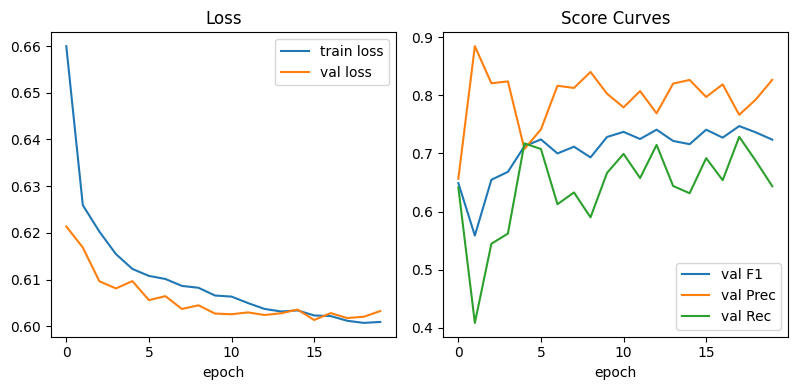


🏆 Best val loss: 0.6013
🏆 Best val F1:   0.7471



In [16]:
import os, time
import torch, torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from google.colab import drive

# ─── A) CONFIG ────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n▶ Using device: {device}\n")

in_ch = 23   # only original Sentinel-2 bands for now
model, loss_fn, optimizer = make_model(in_ch)
model.to(device)
print(model, "\n")

# quick sanity‐check on 1 batch
batch = next(iter(train_loader), None)
if batch:
    imgs, masks = batch
    imgs, masks = imgs.to(device), masks.to(device)
    model.train(); optimizer.zero_grad()
    loss = loss_fn(model(imgs), masks)
    loss.backward(); optimizer.step()
    print(f"✔ Sanity-check loss: {loss.item():.4f}\n")
else:
    print("⚠️ train_loader is empty!\n")

# ─── B) TRAIN/VAL LOOP ─────────────────────────────────────────────────────────
NUM_EPOCHS     = 20
# Mount drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the path to save the model in Google Drive with the specified naming convention
# DRIVE_SAVE_PATH = "/content/drive/My Drive/LandslideDetection/Ensemble_Models/DeepLabV3_CombinedLoss_Model.pth"
CHECKPOINT_DIR = "./checkpoints" # Keep local checkpoints as well
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

best_val_loss = float("inf")
best_val_f1   = -1

train_losses, val_losses, val_f1s = [], [], []
val_precs, val_recs = [], []

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()

    # — Train —
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch{epoch:02d} Train", leave=False)
    for imgs, masks in pbar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = loss_fn(logits, masks)
        loss.backward(); optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(loss=f"{running_loss/((pbar.n+1)*imgs.size(0)):.4f}")
    train_loss = running_loss / len(train_loader.dataset)

    # — Validate —
    model.eval()
    running_loss = 0.0
    y_true, y_prob_raw = [], []
    pbar = tqdm(val_loader, desc=f"Epoch{epoch:02d} Val  ", leave=False)
    with torch.no_grad():
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss   = loss_fn(logits, masks)
            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix(loss=f"{running_loss/((pbar.n+1)*imgs.size(0)):.4f}")

            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            y_prob_raw.append(probs)
            y_true.append(masks.cpu().numpy().ravel().astype(int))

    val_loss = running_loss / len(val_loader.dataset)
    y_true = np.concatenate(y_true)
    y_prob_raw = np.concatenate(y_prob_raw)

    # 🧪 Threshold sweep
    thresholds = [0.5, 0.6, 0.75, 0.85, 0.9, 0.95]
    best_t, best_f1_epoch = 0, 0 # Rename best_f1 to best_f1_epoch to avoid conflict
    for t in thresholds:
        y_pred = (y_prob_raw > t).astype(int)
        f1  = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1_epoch: # Use best_f1_epoch
            best_f1_epoch = f1 # Use best_f1_epoch
            best_t = t

    # Final metrics for best threshold
    final_preds = (y_prob_raw > best_t).astype(int)
    val_f1   = f1_score(y_true, final_preds, zero_division=0)
    val_prec = precision_score(y_true, final_preds, zero_division=0)
    val_rec  = recall_score(y_true, final_preds, zero_division=0)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)
    val_precs.append(val_prec)
    val_recs.append(val_rec)

    # Logging
    msg = (f"[E{epoch:02d}] tr_loss={train_loss:.4f}  "
           f"val_loss={val_loss:.4f}  f1={val_f1:.4f}  "
           f"prec={val_prec:.4f}  rec={val_rec:.4f}  "
           f"best_thresh={best_t:.2f}  ({time.time()-t0:.1f}s)")

    # Save checkpoints
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),
                   os.path.join(CHECKPOINT_DIR,
                                f"best-loss-epoch{epoch:02d}-{val_loss:.4f}.pth"))
        msg += "  ← best loss"
    if val_f1 > best_val_f1: # Use best_val_f1 here
        best_val_f1 = val_f1 # Update best_val_f1
       ## torch.save(model.state_dict(), DRIVE_SAVE_PATH) # Save to Google Drive
        msg += "  ← best F1"


    print(msg)
# ─── C) PLOT CURVES & FINAL METRICS ─────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_losses, label="train loss")
plt.plot(val_losses,   label="val loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch")

plt.subplot(1,3,2)
plt.plot(val_f1s,  label="val F1")
plt.plot(val_precs,label="val Prec")
plt.plot(val_recs, label="val Rec")
plt.legend(); plt.title("Score Curves"); plt.xlabel("epoch")

plt.tight_layout(); plt.show()

print(f"\n🏆 Best val loss: {best_val_loss:.4f}")
print(f"🏆 Best val F1:   {best_val_f1:.4f}\n")

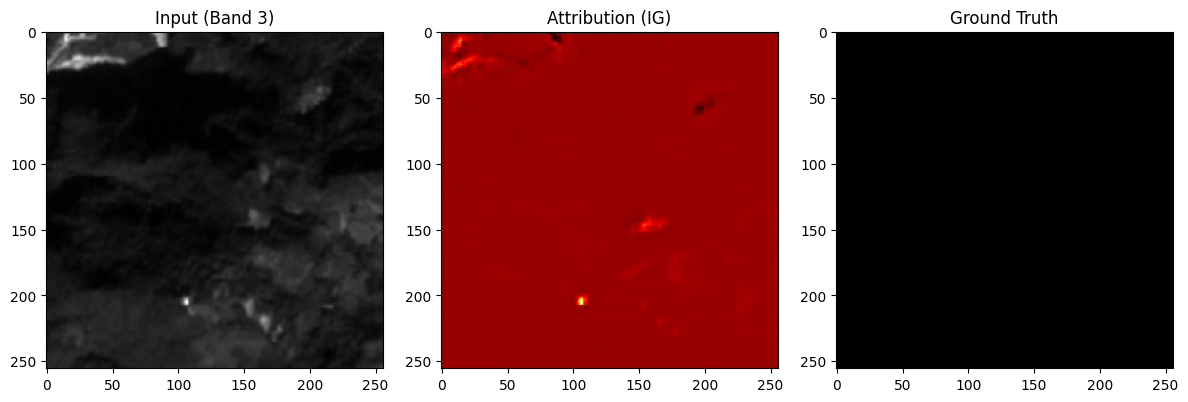

In [ ]:
# 📍 Explainability with Integrated Gradients (Captum)
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

def explain_with_integrated_gradients(model, val_loader, device, sample_idx=0, band_idx=0):
    model.eval()
    sample = next(iter(val_loader))
    imgs, masks = sample
    img  = imgs[sample_idx:sample_idx+1].to(device).requires_grad_()
    mask = masks[sample_idx:sample_idx+1].to(device)

    def forward_func(x):
        return torch.sum(model(x).squeeze(1), dim=(1, 2))

    ig = IntegratedGradients(forward_func)
    attributions = ig.attribute(img)

    # Visualize
    input_np = img[0][band_idx].detach().cpu().numpy()       # visualize 1 band
    attr_np  = attributions[0][band_idx].detach().cpu().numpy()
    mask_np  = mask[0][0].detach().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(input_np, cmap='gray'); plt.title(f"Input (Band {band_idx})")
    plt.subplot(1, 3, 2); plt.imshow(attr_np, cmap='hot'); plt.title("Attribution (IG)")
    plt.subplot(1, 3, 3); plt.imshow(mask_np, cmap='gray'); plt.title("Ground Truth")
    plt.tight_layout(); plt.show()

# 🔧 Call after training
# example: Band 3 (Red), sample index 0
explain_with_integrated_gradients(model, val_loader, device, sample_idx=0, band_idx=3)

In [ ]:
import os, time, torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def train_and_save(model, name, train_loader, val_loader,
                   loss_fn, optimizer, device, epochs=20):
    """
    Trains `model` for `epochs` epochs, saves best-F1 checkpoint to
    f"{name}_best_f1.pth", and returns nothing.
    """
    best_f1 = -1.0
    os.makedirs("checkpoints", exist_ok=True)

    train_losses, val_losses, val_f1s = [], [], []
    for epoch in range(1, epochs+1):
        t0 = time.time()
        # — Train —
        model.train()
        running_loss = 0.0
        for imgs, masks in tqdm(train_loader, desc=f"{name} E{epoch:02d} Train", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss   = loss_fn(logits, masks)
            loss.backward(); optimizer.step()
            running_loss += loss.item()*imgs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # — Validate —
        model.eval()
        running_loss = 0.0
        all_true, all_pred = [], []
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"{name} E{epoch:02d} Val  ", leave=False):
                imgs, masks = imgs.to(device), masks.to(device)
                logits = model(imgs)
                loss   = loss_fn(logits, masks)
                running_loss += loss.item()*imgs.size(0)

                probs = torch.sigmoid(logits).cpu().numpy().ravel()
                pred  = (probs > 0.5).astype(int)
                all_pred.append(pred)
                all_true.append(masks.cpu().numpy().ravel().astype(int))

        val_loss = running_loss / len(val_loader.dataset)
        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
        val_f1 = f1_score(y_true, y_pred, zero_division=0)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        msg = (f"[{name} E{epoch:02d}] tr_loss={train_loss:.4f}  "
               f"val_loss={val_loss:.4f}  val_f1={val_f1:.4f}  "
               f"({time.time()-t0:.1f}s)")
        if val_f1 > best_f1:
            best_f1 = val_f1
            ckpt = f"checkpoints/{name}_best_f1.pth"
            torch.save(model.state_dict(), ckpt)
            msg += "  ← best F1"
        print(msg)

    # Plot learning curves if you like
    plt.figure(figsize=(8,4))
    plt.plot(val_f1s, label="val F1")
    plt.title(f"{name} Validation F1"); plt.xlabel("epoch"); plt.ylabel("F1")
    plt.legend(); plt.show()

In [24]:
%cd /content/drive/MyDrive/LandslideDetection



/content/drive/MyDrive/LandslideDetection


**Note:**

*   Replace `"your_email@example.com"` and `"Your Name"` with your actual GitHub email and name.
*   Replace `"your_notebook_name.ipynb"` with the name of your notebook file.
*   Ensure the paths in the copy commands (`!cp` and `!cp -r`) correctly point to your notebook and the contents of your Google Drive folder.
*   You might be prompted to enter your GitHub username and password or a personal access token when pushing.